# Compare JJA 500hPa geopotential height

Author: Ziqi Yin

Last modified: 2025 Feb 21

Table of contents:
* [Maps of summer 500hPa geopotential height for F09M, F09 and ARCTIC.](#first-bullet)
* [Maps of summer 500hPa geopotential height differences between F09M, F09 and ARCTIC over the NH.](#second-bullet)

Note the plot of ARCTIC grid needs the kernel: 'my-kernel'.

In [1]:
import numpy as np
import numpy.ma as ma
import xarray as xr
from statistics import mode
import pandas as pd
from scipy import signal
from scipy import interpolate

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.colors as colors
from matplotlib.collections import PolyCollection
import cartopy
import cartopy.crs as ccrs
crs_np = ccrs.NorthPolarStereo(central_longitude=0)
crs_ll = ccrs.PlateCarree()
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import geocat.comp as gc #to interpolate and extrapolate data from hybrid-sigma levels to isobaric levels

home_dir = '/glade/work/ziqiyin/'
import sys  
sys.path.insert(0, home_dir)
sys.path.append(home_dir + 'function/')
from functions import *

import warnings
warnings.filterwarnings('ignore')

# For regridding
import os
import ESMF
#import xesmf as xe

In [2]:
## Parameter
g = 9.80616 #[m/s2]
Rd = 287.0423 #[J/kg/K]
p0 = 1e5 #[Pa]

## 1. Z500 <a class="anchor" id="first-bullet"></a>

### Read data

In [3]:
## BG iteration 7
BG7_Z3_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_Z3_JJA_yearly.nc')['Z3'] #geopotential height(asl) [m]
BG7_PS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_PS_JJA_yearly.nc')['PS'] #surface pressure [Pa]
BG7_Tbot_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_T_JJA_yearly.nc')['T'].isel(lev=-1) #bottom layer temperature [K]
BG7_PHIS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_PHIS_JJA_yearly.nc')['PHIS'] #surface geopotential [m2/s2]
hyam = xr.open_dataset('/glade/campaign/cesm/development/liwg/CESM21-CISM2-JG-BG-Dec2018/archive/BG_iteration_7/atm/hist/BG_iteration_7.cam.h0.0001-12.nc')['hyam'] #hybrid A coefficient at layer midpoints [] 
hybm = xr.open_dataset('/glade/campaign/cesm/development/liwg/CESM21-CISM2-JG-BG-Dec2018/archive/BG_iteration_7/atm/hist/BG_iteration_7.cam.h0.0001-12.nc')['hybm'] #hybrid B coefficient at layer midpoints []
f09_lon = BG7_Z3_JJA_yearly.lon
f09_lat = BG7_Z3_JJA_yearly.lat

In [4]:
## f09muntjewerf
# 1pctCO2
f09_1pctCO2_Z3_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_Z3_1pctCO2_JJA_yearly.nc')['Z3'][:140,:,:,:]
f09_1pctCO2_PS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PS_1pctCO2_JJA_yearly.nc')['PS'][:140,:,:]
f09_1pctCO2_Tbot_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_T_1pctCO2_JJA_yearly.nc')['T'][:140,:,:,:].isel(lev=-1)
f09_1pctCO2_PHIS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PHIS_1pctCO2_JJA_yearly.nc')['PHIS'][:140,:,:]

# 4xext
f09_4xext_Z3_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_Z3_4xext_JJA_yearly.nc')['Z3']
f09_4xext_PS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PS_4xext_JJA_yearly.nc')['PS']
f09_4xext_Tbot_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_T_4xext_JJA_yearly.nc')['T'].isel(lev=-1)
f09_4xext_PHIS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PHIS_4xext_JJA_yearly.nc')['PHIS']

In [5]:
## f09nohacks
# piControl
f09_nohacks_piControl_Z3_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_Z3_piControl_JJA_yearly.nc')['Z3']
f09_nohacks_piControl_PS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PS_piControl_JJA_yearly.nc')['PS']
f09_nohacks_piControl_Tbot_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_T_piControl_JJA_yearly.nc')['T'].isel(lev=-1)
f09_nohacks_piControl_PHIS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PHIS_piControl_JJA_yearly.nc')['PHIS']

# 1pctCO2
f09_nohacks_1pctCO2_Z3_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_Z3_1pctCO2_JJA_yearly.nc')['Z3']
f09_nohacks_1pctCO2_PS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PS_1pctCO2_JJA_yearly.nc')['PS']
f09_nohacks_1pctCO2_Tbot_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_T_1pctCO2_JJA_yearly.nc')['T'].isel(lev=-1)
f09_nohacks_1pctCO2_PHIS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PHIS_1pctCO2_JJA_yearly.nc')['PHIS']

# 4xext
f09_nohacks_4xext_Z3_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_Z3_4xext_JJA_yearly.nc')['Z3']
f09_nohacks_4xext_PS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PS_4xext_JJA_yearly.nc')['PS']
f09_nohacks_4xext_Tbot_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_T_4xext_JJA_yearly.nc')['T'].isel(lev=-1)
f09_nohacks_4xext_PHIS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PHIS_4xext_JJA_yearly.nc')['PHIS']

In [6]:
## Arctic grid
# piControl
ARCTIC_piControl_p4_Z3_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_Z3_piControl_p4_JJA_yearly.nc')['Z3']
ARCTIC_piControl_p4_PS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PS_piControl_p4_JJA_yearly.nc')['PS']
ARCTIC_piControl_p4_Tbot_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_T_piControl_p4_JJA_yearly.nc')['T'].isel(lev=-1)
ARCTIC_piControl_p4_PHIS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PHIS_piControl_p4_JJA_yearly.nc')['PHIS']

# 1pctCO2
ARCTIC_1pctCO2_Z3_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_Z3_1pctCO2_JJA_yearly.nc')['Z3']
ARCTIC_1pctCO2_PS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PS_1pctCO2_JJA_yearly.nc')['PS']
ARCTIC_1pctCO2_Tbot_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_T_1pctCO2_JJA_yearly.nc')['T'].isel(lev=-1)
ARCTIC_1pctCO2_PHIS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PHIS_1pctCO2_JJA_yearly.nc')['PHIS']

# 4xext
ARCTIC_4xext_Z3_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_Z3_4xext_JJA_yearly.nc')['Z3']
ARCTIC_4xext_PS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PS_4xext_JJA_yearly.nc')['PS']
ARCTIC_4xext_Tbot_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_T_4xext_JJA_yearly.nc')['T'].isel(lev=-1)
ARCTIC_4xext_PHIS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PHIS_4xext_JJA_yearly.nc')['PHIS']

### Calculate

In [ ]:
# Concat 1pctCO2 and 4xext periods
f09_1pctCO2_4xext_Z3_JJA_yearly = xr.concat([f09_1pctCO2_Z3_JJA_yearly, f09_4xext_Z3_JJA_yearly], dim='time')
f09_1pctCO2_4xext_PS_JJA_yearly = xr.concat([f09_1pctCO2_PS_JJA_yearly, f09_4xext_PS_JJA_yearly], dim='time')
f09_1pctCO2_4xext_Tbot_JJA_yearly = xr.concat([f09_1pctCO2_Tbot_JJA_yearly, f09_4xext_Tbot_JJA_yearly], dim='time')
f09_1pctCO2_4xext_PHIS_JJA_yearly = xr.concat([f09_1pctCO2_PHIS_JJA_yearly, f09_4xext_PHIS_JJA_yearly], dim='time')

f09_nohacks_1pctCO2_4xext_Z3_JJA_yearly = xr.concat([f09_nohacks_1pctCO2_Z3_JJA_yearly, f09_nohacks_4xext_Z3_JJA_yearly], dim='time')
f09_nohacks_1pctCO2_4xext_PS_JJA_yearly = xr.concat([f09_nohacks_1pctCO2_PS_JJA_yearly, f09_nohacks_4xext_PS_JJA_yearly], dim='time')
f09_nohacks_1pctCO2_4xext_Tbot_JJA_yearly = xr.concat([f09_nohacks_1pctCO2_Tbot_JJA_yearly, f09_nohacks_4xext_Tbot_JJA_yearly], dim='time')
f09_nohacks_1pctCO2_4xext_PHIS_JJA_yearly = xr.concat([f09_nohacks_1pctCO2_PHIS_JJA_yearly, f09_nohacks_4xext_PHIS_JJA_yearly], dim='time')

ARCTIC_1pctCO2_4xext_Z3_JJA_yearly = xr.concat([ARCTIC_1pctCO2_Z3_JJA_yearly, ARCTIC_4xext_Z3_JJA_yearly], dim='time')
ARCTIC_1pctCO2_4xext_PS_JJA_yearly = xr.concat([ARCTIC_1pctCO2_PS_JJA_yearly, ARCTIC_4xext_PS_JJA_yearly], dim='time')
ARCTIC_1pctCO2_4xext_Tbot_JJA_yearly = xr.concat([ARCTIC_1pctCO2_Tbot_JJA_yearly, ARCTIC_4xext_Tbot_JJA_yearly], dim='time')
ARCTIC_1pctCO2_4xext_PHIS_JJA_yearly = xr.concat([ARCTIC_1pctCO2_PHIS_JJA_yearly, ARCTIC_4xext_PHIS_JJA_yearly], dim='time')

In [ ]:
## Select
# end of PI (year -19-0)
f09_Z3_JJA_PI = BG7_Z3_JJA_yearly[129:149,:,:,:].mean(dim='time')
f09_PS_JJA_PI = BG7_PS_JJA_yearly[129:149,:,:].mean(dim='time')
f09_Tbot_JJA_PI = BG7_Tbot_JJA_yearly[129:149,:,:].mean(dim='time')
f09_PHIS_JJA_PI = BG7_PHIS_JJA_yearly[129:149,:,:].mean(dim='time')

f09_nohacks_Z3_JJA_PI = f09_nohacks_piControl_Z3_JJA_yearly[-20:,:,:,:].mean(dim='time')
f09_nohacks_PS_JJA_PI = f09_nohacks_piControl_PS_JJA_yearly[-20:,:,:].mean(dim='time')
f09_nohacks_Tbot_JJA_PI = f09_nohacks_piControl_Tbot_JJA_yearly[-20:,:,:].mean(dim='time')
f09_nohacks_PHIS_JJA_PI = f09_nohacks_piControl_PHIS_JJA_yearly[-20:,:,:].mean(dim='time')

ARCTIC_Z3_JJA_PI = ARCTIC_piControl_p4_Z3_JJA_yearly[-20:,:,:].mean(dim='time')
ARCTIC_PS_JJA_PI = ARCTIC_piControl_p4_PS_JJA_yearly[-20:,:].mean(dim='time')
ARCTIC_Tbot_JJA_PI = ARCTIC_piControl_p4_Tbot_JJA_yearly[-20:,:].mean(dim='time')
ARCTIC_PHIS_JJA_PI = ARCTIC_piControl_p4_PHIS_JJA_yearly[-20:,:].mean(dim='time')

# CO2 stabilization (year 131-150)
f09_Z3_JJA_stab = f09_1pctCO2_4xext_Z3_JJA_yearly[130:150,:,:,:].mean(dim='time')
f09_PS_JJA_stab = f09_1pctCO2_4xext_PS_JJA_yearly[130:150,:,:].mean(dim='time')
f09_Tbot_JJA_stab = f09_1pctCO2_4xext_Tbot_JJA_yearly[130:150,:,:].mean(dim='time')
f09_PHIS_JJA_stab = f09_1pctCO2_4xext_PHIS_JJA_yearly[130:150,:,:].mean(dim='time')

f09_nohacks_Z3_JJA_stab = f09_nohacks_1pctCO2_4xext_Z3_JJA_yearly[130:150,:,:,:].mean(dim='time')
f09_nohacks_PS_JJA_stab = f09_nohacks_1pctCO2_4xext_PS_JJA_yearly[130:150,:,:].mean(dim='time')
f09_nohacks_Tbot_JJA_stab = f09_nohacks_1pctCO2_4xext_Tbot_JJA_yearly[130:150,:,:].mean(dim='time')
f09_nohacks_PHIS_JJA_stab = f09_nohacks_1pctCO2_4xext_PHIS_JJA_yearly[130:150,:,:].mean(dim='time')

ARCTIC_Z3_JJA_stab = ARCTIC_1pctCO2_4xext_Z3_JJA_yearly[130:150,:,:].mean(dim='time')
ARCTIC_PS_JJA_stab = ARCTIC_1pctCO2_4xext_PS_JJA_yearly[130:150,:].mean(dim='time')
ARCTIC_Tbot_JJA_stab = ARCTIC_1pctCO2_4xext_Tbot_JJA_yearly[130:150,:].mean(dim='time')
ARCTIC_PHIS_JJA_stab = ARCTIC_1pctCO2_4xext_PHIS_JJA_yearly[130:150,:].mean(dim='time')

# middle period (year 231-250)
f09_Z3_JJA_mid = f09_1pctCO2_4xext_Z3_JJA_yearly[230:250,:,:,:].mean(dim='time')
f09_PS_JJA_mid = f09_1pctCO2_4xext_PS_JJA_yearly[230:250,:,:].mean(dim='time')
f09_Tbot_JJA_mid = f09_1pctCO2_4xext_Tbot_JJA_yearly[230:250,:,:].mean(dim='time')
f09_PHIS_JJA_mid = f09_1pctCO2_4xext_PHIS_JJA_yearly[230:250,:,:].mean(dim='time')

f09_nohacks_Z3_JJA_mid = f09_nohacks_1pctCO2_4xext_Z3_JJA_yearly[230:250,:,:,:].mean(dim='time')
f09_nohacks_PS_JJA_mid = f09_nohacks_1pctCO2_4xext_PS_JJA_yearly[230:250,:,:].mean(dim='time')
f09_nohacks_Tbot_JJA_mid = f09_nohacks_1pctCO2_4xext_Tbot_JJA_yearly[230:250,:,:].mean(dim='time')
f09_nohacks_PHIS_JJA_mid = f09_nohacks_1pctCO2_4xext_PHIS_JJA_yearly[230:250,:,:].mean(dim='time')

ARCTIC_Z3_JJA_mid = ARCTIC_1pctCO2_4xext_Z3_JJA_yearly[230:250,:,:].mean(dim='time')
ARCTIC_PS_JJA_mid = ARCTIC_1pctCO2_4xext_PS_JJA_yearly[230:250,:].mean(dim='time')
ARCTIC_Tbot_JJA_mid = ARCTIC_1pctCO2_4xext_Tbot_JJA_yearly[230:250,:].mean(dim='time')
ARCTIC_PHIS_JJA_mid = ARCTIC_1pctCO2_4xext_PHIS_JJA_yearly[230:250,:].mean(dim='time')

# end of simulation (year 331-350)
f09_Z3_JJA_end = f09_4xext_Z3_JJA_yearly[-20:,:,:,:].mean(dim='time')
f09_PS_JJA_end = f09_4xext_PS_JJA_yearly[-20:,:,:].mean(dim='time')
f09_Tbot_JJA_end = f09_4xext_Tbot_JJA_yearly[-20:,:,:].mean(dim='time')
f09_PHIS_JJA_end = f09_4xext_PHIS_JJA_yearly[-20:,:,:].mean(dim='time')

f09_nohacks_Z3_JJA_end = f09_nohacks_4xext_Z3_JJA_yearly[-20:,:,:,:].mean(dim='time')
f09_nohacks_PS_JJA_end = f09_nohacks_4xext_PS_JJA_yearly[-20:,:,:].mean(dim='time')
f09_nohacks_Tbot_JJA_end = f09_nohacks_4xext_Tbot_JJA_yearly[-20:,:,:].mean(dim='time')
f09_nohacks_PHIS_JJA_end = f09_nohacks_4xext_PHIS_JJA_yearly[-20:,:,:].mean(dim='time')

ARCTIC_Z3_JJA_end = ARCTIC_4xext_Z3_JJA_yearly[-20:,:,:].mean(dim='time')
ARCTIC_PS_JJA_end = ARCTIC_4xext_PS_JJA_yearly[-20:,:].mean(dim='time')
ARCTIC_Tbot_JJA_end = ARCTIC_4xext_Tbot_JJA_yearly[-20:,:].mean(dim='time')
ARCTIC_PHIS_JJA_end = ARCTIC_4xext_PHIS_JJA_yearly[-20:,:].mean(dim='time')

In [ ]:
## Interpolate to 500hPa level or extrapolate to 1000hPa level
# interp_hybrid_to_pressure is the Python version of vinth2p/vinth2p_ecmwf (for extrapolation below ground) in NCL script

# 500 hPa level
pnew = np.array([500]) *100

f09_Z500_JJA_PI = gc.interp_hybrid_to_pressure(data=f09_Z3_JJA_PI, ps=f09_PS_JJA_PI, hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze() #'linear' or 'log'
f09_nohacks_Z500_JJA_PI = gc.interp_hybrid_to_pressure(data=f09_nohacks_Z3_JJA_PI, ps=f09_nohacks_PS_JJA_PI, hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze()
ARCTIC_Z500_JJA_PI = gc.interp_hybrid_to_pressure(data=ARCTIC_Z3_JJA_PI, ps=ARCTIC_PS_JJA_PI, hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze()

f09_Z500_JJA_stab = gc.interp_hybrid_to_pressure(data=f09_Z3_JJA_stab, ps=f09_PS_JJA_stab, hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze() #'linear' or 'log'
f09_nohacks_Z500_JJA_stab = gc.interp_hybrid_to_pressure(data=f09_nohacks_Z3_JJA_stab, ps=f09_nohacks_PS_JJA_stab, hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze()
ARCTIC_Z500_JJA_stab = gc.interp_hybrid_to_pressure(data=ARCTIC_Z3_JJA_stab, ps=ARCTIC_PS_JJA_stab, hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze()

f09_Z500_JJA_mid = gc.interp_hybrid_to_pressure(data=f09_Z3_JJA_mid, ps=f09_PS_JJA_mid, hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze() #'linear' or 'log'
f09_nohacks_Z500_JJA_mid = gc.interp_hybrid_to_pressure(data=f09_nohacks_Z3_JJA_mid, ps=f09_nohacks_PS_JJA_mid, hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze()
ARCTIC_Z500_JJA_mid = gc.interp_hybrid_to_pressure(data=ARCTIC_Z3_JJA_mid, ps=ARCTIC_PS_JJA_mid, hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze()

f09_Z500_JJA_end = gc.interp_hybrid_to_pressure(data=f09_Z3_JJA_end, ps=f09_PS_JJA_end, hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze() #'linear' or 'log'
f09_nohacks_Z500_JJA_end = gc.interp_hybrid_to_pressure(data=f09_nohacks_Z3_JJA_end, ps=f09_nohacks_PS_JJA_end, hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze()
ARCTIC_Z500_JJA_end = gc.interp_hybrid_to_pressure(data=ARCTIC_Z3_JJA_end, ps=ARCTIC_PS_JJA_end, hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze()

In [ ]:
## Add cyclic points
f09_Z500_JJA_stab2, f09_lon2 = add_cyclic_point(f09_Z500_JJA_stab, coord=f09_lon)
f09_nohacks_Z500_JJA_stab2, f09_lon2 = add_cyclic_point(f09_nohacks_Z500_JJA_stab, coord=f09_lon)

f09_Z500_JJA_mid2, f09_lon2 = add_cyclic_point(f09_Z500_JJA_mid, coord=f09_lon)
f09_nohacks_Z500_JJA_mid2, f09_lon2 = add_cyclic_point(f09_nohacks_Z500_JJA_mid, coord=f09_lon)

f09_Z500_JJA_end2, f09_lon2 = add_cyclic_point(f09_Z500_JJA_end, coord=f09_lon)
f09_nohacks_Z500_JJA_end2, f09_lon2 = add_cyclic_point(f09_nohacks_Z500_JJA_end, coord=f09_lon)

### Prepare for plotting SE grids

In [12]:
# Scrip files (contains grid information)
# From github page and more in /glade/work/aherring/grids/SCRIP_files/
scrip_fname_f09 = home_dir + 'data/gridfile/fv0.9x1.25_scrip_141008.nc'
scrip_fname_ARCTIC = home_dir + 'data/gridfile/ne0ARCTICne30x4_scrip_191212.nc'

f09_scrip = xr.open_dataset(scrip_fname_f09)
ARCTIC_scrip = xr.open_dataset(scrip_fname_ARCTIC)

In [13]:
# Modified from the Plot_2D() function with link below
def get_var_verts(scrip_fname, var_in):

    # Read scrip file in case of SE model output
    ds_scrip = xr.open_dataset(scrip_fname)
    corner_lon = np.copy(ds_scrip.grid_corner_lon.values)
    corner_lat = np.copy(ds_scrip.grid_corner_lat.values)
    center_lon = np.copy(ds_scrip.grid_center_lon.values)
    center_lat = np.copy(ds_scrip.grid_center_lat.values)

    var0 = var_in # [ ]
    var = np.copy(var0.values)
    lon_range = [-180, 180]

    if ((np.min(lon_range) < 0) & (np.max(corner_lon) > 180)):
        corner_lon[corner_lon > 180.] -= 360.
        
    # set vertices for SE model output
    lons_corners = np.copy(corner_lon.reshape(corner_lon.shape[0], corner_lon.shape[1],1))
    lats_corners = np.copy(corner_lat.reshape(corner_lat.shape[0], corner_lat.shape[1],1))
    lons_corners[lons_corners > 180.] -= 360
    center_lon[center_lon > 180.] -= 360

    lons_corners_add = []
    lats_corners_add = []
    var_add = []
    # For longitudes -180, 180
    for i, cenlon in enumerate(center_lon):
        lon_maxmin = np.max(lons_corners[i,:,:]) - \
                     np.min(lons_corners[i,:,:])
        if (lon_maxmin > 180):
            if np.mean(lons_corners[i,:,:]) <= 0:
                inds2 = np.where(lons_corners[i,:,:] < 0)[0]
                tmp_lons_corners = np.copy(lons_corners[i,:])
                tmp_lons_corners[inds2] = 180.
                lons_corners_add.append(tmp_lons_corners)
                lats_corners_add.append(lats_corners[i,:])

                inds = np.where(lons_corners[i,:,:] > 0)[0]
                lons_corners[i,inds] = -180.

                var_add.append(var[i])

            elif np.mean(lons_corners[i,:,:]) > 0:
                inds2 = np.where(lons_corners[i,:,:] > 0)[0]
                tmp_lons_corners = np.copy(lons_corners[i,:])
                tmp_lons_corners[inds2] = -180.
                lons_corners_add.append(tmp_lons_corners)
                lats_corners_add.append(lats_corners[i,:])

                inds = np.where(lons_corners[i,:,:] < 0)[0]
                lons_corners[i,inds] = 180.

                var_add.append(var[i])

    lons_corners = np.concatenate((lons_corners, np.array(lons_corners_add)), axis=0)
    lats_corners = np.concatenate((lats_corners, np.array(lats_corners_add)), axis=0)
    var = np.concatenate((var, np.array(var_add)), axis=0)

    verts = np.concatenate((lons_corners, lats_corners), axis=2)
    
    return var, verts

In [14]:
ARCTIC_Z500_JJA_PI_var = get_var_verts(scrip_fname_ARCTIC, xr.DataArray(ARCTIC_Z500_JJA_PI))[0]
ARCTIC_Z500_JJA_PI_verts = get_var_verts(scrip_fname_ARCTIC, xr.DataArray(ARCTIC_Z500_JJA_PI))[1]

ARCTIC_Z500_JJA_stab_var = get_var_verts(scrip_fname_ARCTIC, xr.DataArray(ARCTIC_Z500_JJA_stab))[0]
ARCTIC_Z500_JJA_stab_verts = get_var_verts(scrip_fname_ARCTIC, xr.DataArray(ARCTIC_Z500_JJA_stab))[1]

ARCTIC_Z500_JJA_mid_var = get_var_verts(scrip_fname_ARCTIC, xr.DataArray(ARCTIC_Z500_JJA_mid))[0]
ARCTIC_Z500_JJA_mid_verts = get_var_verts(scrip_fname_ARCTIC, xr.DataArray(ARCTIC_Z500_JJA_mid))[1]

ARCTIC_Z500_JJA_end_var = get_var_verts(scrip_fname_ARCTIC, xr.DataArray(ARCTIC_Z500_JJA_end))[0]
ARCTIC_Z500_JJA_end_verts = get_var_verts(scrip_fname_ARCTIC, xr.DataArray(ARCTIC_Z500_JJA_end))[1]

In [15]:
# Dictionary declaration for keywords in external function call
kwd_polycollection = {}
kwd_polycollection['edgecolor'] = 'face'
#kwd_polycollection['norm'] = \
#                    matplotlib.colors.SymLogNorm( linthresh=self.linthresh,
#                                                  linscale=self.linscale,
#                                                  vmin=self.cmin, vmax=self.cmax )

### Plot

In [3]:
### --- Plot basemap of Antarctica with cartopy --- ###
def plot_arctic(ax, lat):

    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.51
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([-180, 180, lat, 90], ccrs.PlateCarree())
    return

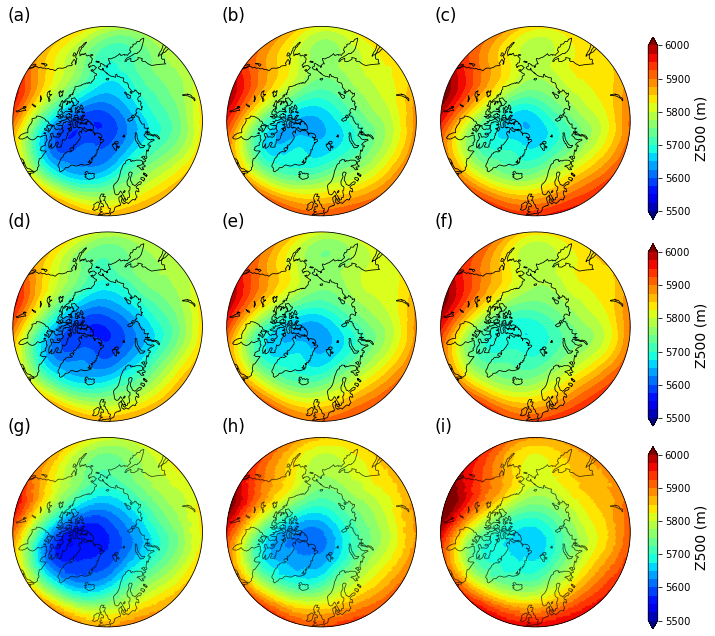

In [16]:
fig = plt.figure(figsize = (11,11))
gs=GridSpec(3,3)
plt.rcParams['axes.titlepad'] = 14

# Modify values here
cmap2 = plt.cm.jet
bounds2 = np.arange(5500.,6000.1,25)
bounds2min = [0]
bounds2max = [10000]
norm2 = mpl.colors.BoundaryNorm(bounds2, cmap2.N, extend='both')
ticks2 = np.arange(5500.,6000.1,100)

#=============F09M===============
ax1 = plt.subplot(gs[0],projection=crs_np)
plot_arctic(ax1,50)
im1 = ax1.contourf(f09_lon2, f09_lat, f09_Z500_JJA_stab2, cmap=cmap2, levels=bounds2, norm=norm2, extend='both', transform=crs_ll, zorder=1)
ax1.add_feature(cfeature.LAND, zorder=2, facecolor='none')
ax1.add_feature(cfeature.COASTLINE, zorder=3, color='black', lw=0.8)
ax1.add_feature(cfeature.LAKES, zorder=4, edgecolor='black', lw=0.8, facecolor='none')
plt.text(-5000000, 5000000, '(a)', fontsize=17)

ax2 = plt.subplot(gs[1],projection=crs_np)
plot_arctic(ax2,50)
im2 = ax2.contourf(f09_lon2, f09_lat, f09_Z500_JJA_mid2, cmap=cmap2, levels=bounds2, norm=norm2, extend='both', transform=crs_ll, zorder=1)
ax2.add_feature(cfeature.LAND, zorder=2, facecolor='none')
ax2.add_feature(cfeature.COASTLINE, zorder=3, color='black', lw=0.8)
ax2.add_feature(cfeature.LAKES, zorder=4, edgecolor='black', lw=0.8, facecolor='none')
plt.text(-5000000, 5000000, '(b)', fontsize=17)

ax3 = plt.subplot(gs[2],projection=crs_np)
plot_arctic(ax3,50)
im3 = ax3.contourf(f09_lon2, f09_lat, f09_Z500_JJA_end2, cmap=cmap2, levels=bounds2, norm=norm2, extend='both', transform=crs_ll, zorder=1)
ax3.add_feature(cfeature.LAND, zorder=2, facecolor='none')
ax3.add_feature(cfeature.COASTLINE, zorder=3, color='black', lw=0.8)
ax3.add_feature(cfeature.LAKES, zorder=4, edgecolor='black', lw=0.8, facecolor='none')
plt.text(-5000000, 5000000, '(c)', fontsize=17)

cbar_ax3 = fig.add_axes([0.925, 0.638, 0.012, 0.23])
cb3 = fig.colorbar(im3, cax=cbar_ax3, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb3.set_label(label='Z500 (m)', size=14)
cb3.ax.tick_params(labelsize=10)

#=============F09===============

ax4 = plt.subplot(gs[3],projection=crs_np)
plot_arctic(ax4,50)
im4 = ax4.contourf(f09_lon2, f09_lat, f09_nohacks_Z500_JJA_stab2, cmap=cmap2, levels=bounds2, norm=norm2, extend='both', transform=crs_ll, zorder=1)
ax4.add_feature(cfeature.LAND, zorder=2, facecolor='none')
ax4.add_feature(cfeature.COASTLINE, zorder=3, color='black', lw=0.8)
ax4.add_feature(cfeature.LAKES, zorder=4, edgecolor='black', lw=0.8, facecolor='none')
plt.text(-5000000, 5000000, '(d)', fontsize=17)

ax5 = plt.subplot(gs[4],projection=crs_np)
plot_arctic(ax5,50)
im5 = ax5.contourf(f09_lon2, f09_lat, f09_nohacks_Z500_JJA_mid2, cmap=cmap2, levels=bounds2, norm=norm2, extend='both', transform=crs_ll, zorder=1)
ax5.add_feature(cfeature.LAND, zorder=2, facecolor='none')
ax5.add_feature(cfeature.COASTLINE, zorder=3, color='black', lw=0.8)
ax5.add_feature(cfeature.LAKES, zorder=4, edgecolor='black', lw=0.8, facecolor='none')
plt.text(-5000000, 5000000, '(e)', fontsize=17)

ax6 = plt.subplot(gs[5],projection=crs_np)
plot_arctic(ax6,50)
im6 = ax6.contourf(f09_lon2, f09_lat, f09_nohacks_Z500_JJA_end2, cmap=cmap2, levels=bounds2, norm=norm2, extend='both', transform=crs_ll, zorder=1)
ax6.add_feature(cfeature.LAND, zorder=2, facecolor='none')
ax6.add_feature(cfeature.COASTLINE, zorder=3, color='black', lw=0.8)
ax6.add_feature(cfeature.LAKES, zorder=4, edgecolor='black', lw=0.8, facecolor='none')
plt.text(-5000000, 5000000, '(f)', fontsize=17)

#cbar_ax6 = fig.add_axes([0.925, 0.375, 0.012, 0.23]) # for new kernel
cbar_ax6 = fig.add_axes([0.925, 0.377, 0.012, 0.23])
cb6 = fig.colorbar(im6, cax=cbar_ax6, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb6.set_label(label='Z500 (m)', size=14)
cb6.ax.tick_params(labelsize=10)

#=============ARCTIC===============
ax7 = plt.subplot(gs[6],projection=crs_np)
plot_arctic(ax7,50)
im7 = PolyCollection(ARCTIC_Z500_JJA_stab_verts, cmap=cmap2, transform=crs_ll, norm=norm2,
                     **kwd_polycollection)
im7.set_array(ARCTIC_Z500_JJA_stab_var)
im7.set_clim(vmin=5500, vmax=6000)
ax7.add_collection(im7)
ax7.add_feature(cfeature.LAND, facecolor='none')
ax7.add_feature(cfeature.COASTLINE, color='black', lw=0.8, alpha=0.7)
ax7.add_feature(cfeature.LAKES, edgecolor='black', lw=0.8, alpha=0.7, facecolor='none')
plt.text(-5000000, 5000000, '(g)', fontsize=17)

ax8 = plt.subplot(gs[7],projection=crs_np)
plot_arctic(ax8,50)
im8 = PolyCollection(ARCTIC_Z500_JJA_mid_verts, cmap=cmap2, transform=crs_ll, norm=norm2,
                     **kwd_polycollection)
im8.set_array(ARCTIC_Z500_JJA_mid_var)
im8.set_clim(vmin=5500, vmax=6000)
ax8.add_collection(im8)
ax8.add_feature(cfeature.LAND, facecolor='none')
ax8.add_feature(cfeature.COASTLINE, color='black', lw=0.8, alpha=0.7)
ax8.add_feature(cfeature.LAKES, edgecolor='black', lw=0.8, alpha=0.7, facecolor='none')
plt.text(-5000000, 5000000, '(h)', fontsize=17)

ax9 = plt.subplot(gs[8],projection=crs_np)
plot_arctic(ax9,50)
im9 = PolyCollection(ARCTIC_Z500_JJA_end_verts, cmap=cmap2, transform=crs_ll, norm=norm2,
                     **kwd_polycollection)
im9.set_array(ARCTIC_Z500_JJA_end_var)
im9.set_clim(vmin=5500, vmax=6000)
ax9.add_collection(im9)
ax9.add_feature(cfeature.LAND, facecolor='none')
ax9.add_feature(cfeature.COASTLINE, color='black', lw=0.8, alpha=0.7)
ax9.add_feature(cfeature.LAKES, edgecolor='black', lw=0.8, alpha=0.7, facecolor='none')
plt.text(-5000000, 5000000, '(i)', fontsize=17)

# colorbar
#cbar_ax9 = fig.add_axes([0.925, 0.113, 0.012, 0.23]) # for new kernel
cbar_ax9 = fig.add_axes([0.925, 0.121, 0.012, 0.23]) # for new kernel
cb9 = fig.colorbar(im9, cax=cbar_ax9, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb9.set_label(label='Z500 (m)', size=14)
cb9.ax.tick_params(labelsize=10)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.15,
                    hspace=0.1)

## 2. Z500 difference <a class="anchor" id="second-bullet"></a>

### Read data

In [3]:
## BG iteration 7
BG7_Z3_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_Z3_JJA_yearly.nc')['Z3'] #geopotential height(asl) [m]
BG7_PS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_PS_JJA_yearly.nc')['PS'] #surface pressure [Pa]
BG7_Tbot_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_T_JJA_yearly.nc')['T'].isel(lev=-1) #bottom layer temperature [K]
BG7_PHIS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_PHIS_JJA_yearly.nc')['PHIS'] #surface geopotential [m2/s2]
hyam = xr.open_dataset('/glade/campaign/cesm/development/liwg/CESM21-CISM2-JG-BG-Dec2018/archive/BG_iteration_7/atm/hist/BG_iteration_7.cam.h0.0001-12.nc')['hyam'] #hybrid A coefficient at layer midpoints [] 
hybm = xr.open_dataset('/glade/campaign/cesm/development/liwg/CESM21-CISM2-JG-BG-Dec2018/archive/BG_iteration_7/atm/hist/BG_iteration_7.cam.h0.0001-12.nc')['hybm'] #hybrid B coefficient at layer midpoints []
f09_lon = BG7_Z3_JJA_yearly.lon
f09_lat = BG7_Z3_JJA_yearly.lat

In [4]:
## f09muntjewerf
# 1pctCO2
f09_1pctCO2_Z3_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_Z3_1pctCO2_JJA_yearly.nc')['Z3'][:140,:,:,:]
f09_1pctCO2_PS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PS_1pctCO2_JJA_yearly.nc')['PS'][:140,:,:]
f09_1pctCO2_Tbot_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_T_1pctCO2_JJA_yearly.nc')['T'][:140,:,:,:].isel(lev=-1)
f09_1pctCO2_PHIS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PHIS_1pctCO2_JJA_yearly.nc')['PHIS'][:140,:,:]

# 4xext
f09_4xext_Z3_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_Z3_4xext_JJA_yearly.nc')['Z3']
f09_4xext_PS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PS_4xext_JJA_yearly.nc')['PS']
f09_4xext_Tbot_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_T_4xext_JJA_yearly.nc')['T'].isel(lev=-1)
f09_4xext_PHIS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PHIS_4xext_JJA_yearly.nc')['PHIS']

In [5]:
## f09nohacks
# piControl
f09_nohacks_piControl_Z3_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_Z3_piControl_JJA_yearly.nc')['Z3']
f09_nohacks_piControl_PS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PS_piControl_JJA_yearly.nc')['PS']
f09_nohacks_piControl_Tbot_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_T_piControl_JJA_yearly.nc')['T'].isel(lev=-1)
f09_nohacks_piControl_PHIS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PHIS_piControl_JJA_yearly.nc')['PHIS']

# 1pctCO2
f09_nohacks_1pctCO2_Z3_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_Z3_1pctCO2_JJA_yearly.nc')['Z3']
f09_nohacks_1pctCO2_PS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PS_1pctCO2_JJA_yearly.nc')['PS']
f09_nohacks_1pctCO2_Tbot_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_T_1pctCO2_JJA_yearly.nc')['T'].isel(lev=-1)
f09_nohacks_1pctCO2_PHIS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PHIS_1pctCO2_JJA_yearly.nc')['PHIS']

# 4xext
f09_nohacks_4xext_Z3_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_Z3_4xext_JJA_yearly.nc')['Z3']
f09_nohacks_4xext_PS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PS_4xext_JJA_yearly.nc')['PS']
f09_nohacks_4xext_Tbot_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_T_4xext_JJA_yearly.nc')['T'].isel(lev=-1)
f09_nohacks_4xext_PHIS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PHIS_4xext_JJA_yearly.nc')['PHIS']

In [6]:
## Arctic grid
# piControl
ARCTIC_piControl_p4_Z3_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_Z3_piControl_p4_JJA_yearly.nc')['Z3']
ARCTIC_piControl_p4_PS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PS_piControl_p4_JJA_yearly.nc')['PS']
ARCTIC_piControl_p4_Tbot_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_T_piControl_p4_JJA_yearly.nc')['T'].isel(lev=-1)
ARCTIC_piControl_p4_PHIS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PHIS_piControl_p4_JJA_yearly.nc')['PHIS']

# 1pctCO2
ARCTIC_1pctCO2_Z3_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_Z3_1pctCO2_JJA_yearly.nc')['Z3']
ARCTIC_1pctCO2_PS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PS_1pctCO2_JJA_yearly.nc')['PS']
ARCTIC_1pctCO2_Tbot_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_T_1pctCO2_JJA_yearly.nc')['T'].isel(lev=-1)
ARCTIC_1pctCO2_PHIS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PHIS_1pctCO2_JJA_yearly.nc')['PHIS']

# 4xext
ARCTIC_4xext_Z3_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_Z3_4xext_JJA_yearly.nc')['Z3']
ARCTIC_4xext_PS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PS_4xext_JJA_yearly.nc')['PS']
ARCTIC_4xext_Tbot_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_T_4xext_JJA_yearly.nc')['T'].isel(lev=-1)
ARCTIC_4xext_PHIS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PHIS_4xext_JJA_yearly.nc')['PHIS']

### Calculate

In [7]:
# Concat 1pctCO2 and 4xext periods
f09_1pctCO2_4xext_Z3_JJA_yearly = xr.concat([f09_1pctCO2_Z3_JJA_yearly, f09_4xext_Z3_JJA_yearly], dim='time')
f09_1pctCO2_4xext_PS_JJA_yearly = xr.concat([f09_1pctCO2_PS_JJA_yearly, f09_4xext_PS_JJA_yearly], dim='time')
f09_1pctCO2_4xext_Tbot_JJA_yearly = xr.concat([f09_1pctCO2_Tbot_JJA_yearly, f09_4xext_Tbot_JJA_yearly], dim='time')
f09_1pctCO2_4xext_PHIS_JJA_yearly = xr.concat([f09_1pctCO2_PHIS_JJA_yearly, f09_4xext_PHIS_JJA_yearly], dim='time')

f09_nohacks_1pctCO2_4xext_Z3_JJA_yearly = xr.concat([f09_nohacks_1pctCO2_Z3_JJA_yearly, f09_nohacks_4xext_Z3_JJA_yearly], dim='time')
f09_nohacks_1pctCO2_4xext_PS_JJA_yearly = xr.concat([f09_nohacks_1pctCO2_PS_JJA_yearly, f09_nohacks_4xext_PS_JJA_yearly], dim='time')
f09_nohacks_1pctCO2_4xext_Tbot_JJA_yearly = xr.concat([f09_nohacks_1pctCO2_Tbot_JJA_yearly, f09_nohacks_4xext_Tbot_JJA_yearly], dim='time')
f09_nohacks_1pctCO2_4xext_PHIS_JJA_yearly = xr.concat([f09_nohacks_1pctCO2_PHIS_JJA_yearly, f09_nohacks_4xext_PHIS_JJA_yearly], dim='time')

ARCTIC_1pctCO2_4xext_Z3_JJA_yearly = xr.concat([ARCTIC_1pctCO2_Z3_JJA_yearly, ARCTIC_4xext_Z3_JJA_yearly], dim='time')
ARCTIC_1pctCO2_4xext_PS_JJA_yearly = xr.concat([ARCTIC_1pctCO2_PS_JJA_yearly, ARCTIC_4xext_PS_JJA_yearly], dim='time')
ARCTIC_1pctCO2_4xext_Tbot_JJA_yearly = xr.concat([ARCTIC_1pctCO2_Tbot_JJA_yearly, ARCTIC_4xext_Tbot_JJA_yearly], dim='time')
ARCTIC_1pctCO2_4xext_PHIS_JJA_yearly = xr.concat([ARCTIC_1pctCO2_PHIS_JJA_yearly, ARCTIC_4xext_PHIS_JJA_yearly], dim='time')

In [8]:
## Select
# end of PI (year -19-0)
f09_Z3_JJA_PI = BG7_Z3_JJA_yearly[129:149,:,:,:].mean(dim='time')
f09_PS_JJA_PI = BG7_PS_JJA_yearly[129:149,:,:].mean(dim='time')
f09_Tbot_JJA_PI = BG7_Tbot_JJA_yearly[129:149,:,:].mean(dim='time')
f09_PHIS_JJA_PI = BG7_PHIS_JJA_yearly[129:149,:,:].mean(dim='time')

f09_nohacks_Z3_JJA_PI = f09_nohacks_piControl_Z3_JJA_yearly[-20:,:,:,:].mean(dim='time')
f09_nohacks_PS_JJA_PI = f09_nohacks_piControl_PS_JJA_yearly[-20:,:,:].mean(dim='time')
f09_nohacks_Tbot_JJA_PI = f09_nohacks_piControl_Tbot_JJA_yearly[-20:,:,:].mean(dim='time')
f09_nohacks_PHIS_JJA_PI = f09_nohacks_piControl_PHIS_JJA_yearly[-20:,:,:].mean(dim='time')

ARCTIC_Z3_JJA_PI = ARCTIC_piControl_p4_Z3_JJA_yearly[-20:,:,:].mean(dim='time')
ARCTIC_PS_JJA_PI = ARCTIC_piControl_p4_PS_JJA_yearly[-20:,:].mean(dim='time')
ARCTIC_Tbot_JJA_PI = ARCTIC_piControl_p4_Tbot_JJA_yearly[-20:,:].mean(dim='time')
ARCTIC_PHIS_JJA_PI = ARCTIC_piControl_p4_PHIS_JJA_yearly[-20:,:].mean(dim='time')

# CO2 stabilization (year 131-150)
f09_Z3_JJA_stab = f09_1pctCO2_4xext_Z3_JJA_yearly[130:150,:,:,:].mean(dim='time')
f09_PS_JJA_stab = f09_1pctCO2_4xext_PS_JJA_yearly[130:150,:,:].mean(dim='time')
f09_Tbot_JJA_stab = f09_1pctCO2_4xext_Tbot_JJA_yearly[130:150,:,:].mean(dim='time')
f09_PHIS_JJA_stab = f09_1pctCO2_4xext_PHIS_JJA_yearly[130:150,:,:].mean(dim='time')

f09_nohacks_Z3_JJA_stab = f09_nohacks_1pctCO2_4xext_Z3_JJA_yearly[130:150,:,:,:].mean(dim='time')
f09_nohacks_PS_JJA_stab = f09_nohacks_1pctCO2_4xext_PS_JJA_yearly[130:150,:,:].mean(dim='time')
f09_nohacks_Tbot_JJA_stab = f09_nohacks_1pctCO2_4xext_Tbot_JJA_yearly[130:150,:,:].mean(dim='time')
f09_nohacks_PHIS_JJA_stab = f09_nohacks_1pctCO2_4xext_PHIS_JJA_yearly[130:150,:,:].mean(dim='time')

ARCTIC_Z3_JJA_stab = ARCTIC_1pctCO2_4xext_Z3_JJA_yearly[130:150,:,:].mean(dim='time')
ARCTIC_PS_JJA_stab = ARCTIC_1pctCO2_4xext_PS_JJA_yearly[130:150,:].mean(dim='time')
ARCTIC_Tbot_JJA_stab = ARCTIC_1pctCO2_4xext_Tbot_JJA_yearly[130:150,:].mean(dim='time')
ARCTIC_PHIS_JJA_stab = ARCTIC_1pctCO2_4xext_PHIS_JJA_yearly[130:150,:].mean(dim='time')

# middle period (year 231-250)
f09_Z3_JJA_mid = f09_1pctCO2_4xext_Z3_JJA_yearly[230:250,:,:,:].mean(dim='time')
f09_PS_JJA_mid = f09_1pctCO2_4xext_PS_JJA_yearly[230:250,:,:].mean(dim='time')
f09_Tbot_JJA_mid = f09_1pctCO2_4xext_Tbot_JJA_yearly[230:250,:,:].mean(dim='time')
f09_PHIS_JJA_mid = f09_1pctCO2_4xext_PHIS_JJA_yearly[230:250,:,:].mean(dim='time')

f09_nohacks_Z3_JJA_mid = f09_nohacks_1pctCO2_4xext_Z3_JJA_yearly[230:250,:,:,:].mean(dim='time')
f09_nohacks_PS_JJA_mid = f09_nohacks_1pctCO2_4xext_PS_JJA_yearly[230:250,:,:].mean(dim='time')
f09_nohacks_Tbot_JJA_mid = f09_nohacks_1pctCO2_4xext_Tbot_JJA_yearly[230:250,:,:].mean(dim='time')
f09_nohacks_PHIS_JJA_mid = f09_nohacks_1pctCO2_4xext_PHIS_JJA_yearly[230:250,:,:].mean(dim='time')

ARCTIC_Z3_JJA_mid = ARCTIC_1pctCO2_4xext_Z3_JJA_yearly[230:250,:,:].mean(dim='time')
ARCTIC_PS_JJA_mid = ARCTIC_1pctCO2_4xext_PS_JJA_yearly[230:250,:].mean(dim='time')
ARCTIC_Tbot_JJA_mid = ARCTIC_1pctCO2_4xext_Tbot_JJA_yearly[230:250,:].mean(dim='time')
ARCTIC_PHIS_JJA_mid = ARCTIC_1pctCO2_4xext_PHIS_JJA_yearly[230:250,:].mean(dim='time')

# end of simulation (year 331-350)
f09_Z3_JJA_end = f09_4xext_Z3_JJA_yearly[-20:,:,:,:].mean(dim='time')
f09_PS_JJA_end = f09_4xext_PS_JJA_yearly[-20:,:,:].mean(dim='time')
f09_Tbot_JJA_end = f09_4xext_Tbot_JJA_yearly[-20:,:,:].mean(dim='time')
f09_PHIS_JJA_end = f09_4xext_PHIS_JJA_yearly[-20:,:,:].mean(dim='time')

f09_nohacks_Z3_JJA_end = f09_nohacks_4xext_Z3_JJA_yearly[-20:,:,:,:].mean(dim='time')
f09_nohacks_PS_JJA_end = f09_nohacks_4xext_PS_JJA_yearly[-20:,:,:].mean(dim='time')
f09_nohacks_Tbot_JJA_end = f09_nohacks_4xext_Tbot_JJA_yearly[-20:,:,:].mean(dim='time')
f09_nohacks_PHIS_JJA_end = f09_nohacks_4xext_PHIS_JJA_yearly[-20:,:,:].mean(dim='time')

ARCTIC_Z3_JJA_end = ARCTIC_4xext_Z3_JJA_yearly[-20:,:,:].mean(dim='time')
ARCTIC_PS_JJA_end = ARCTIC_4xext_PS_JJA_yearly[-20:,:].mean(dim='time')
ARCTIC_Tbot_JJA_end = ARCTIC_4xext_Tbot_JJA_yearly[-20:,:].mean(dim='time')
ARCTIC_PHIS_JJA_end = ARCTIC_4xext_PHIS_JJA_yearly[-20:,:].mean(dim='time')

In [9]:
## Interpolate to 500hPa level or extrapolate to 1000hPa level
# interp_hybrid_to_pressure is the Python version of vinth2p/vinth2p_ecmwf (for extrapolation below ground) in NCL script

# 500 hPa level
pnew = np.array([500]) *100

f09_Z500_JJA_PI = gc.interp_hybrid_to_pressure(data=f09_Z3_JJA_PI, ps=f09_PS_JJA_PI, hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze() #'linear' or 'log'
f09_nohacks_Z500_JJA_PI = gc.interp_hybrid_to_pressure(data=f09_nohacks_Z3_JJA_PI, ps=f09_nohacks_PS_JJA_PI, hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze()
ARCTIC_Z500_JJA_PI = gc.interp_hybrid_to_pressure(data=ARCTIC_Z3_JJA_PI, ps=ARCTIC_PS_JJA_PI, hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze()

f09_Z500_JJA_stab = gc.interp_hybrid_to_pressure(data=f09_Z3_JJA_stab, ps=f09_PS_JJA_stab, hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze() #'linear' or 'log'
f09_nohacks_Z500_JJA_stab = gc.interp_hybrid_to_pressure(data=f09_nohacks_Z3_JJA_stab, ps=f09_nohacks_PS_JJA_stab, hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze()
ARCTIC_Z500_JJA_stab = gc.interp_hybrid_to_pressure(data=ARCTIC_Z3_JJA_stab, ps=ARCTIC_PS_JJA_stab, hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze()

f09_Z500_JJA_mid = gc.interp_hybrid_to_pressure(data=f09_Z3_JJA_mid, ps=f09_PS_JJA_mid, hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze() #'linear' or 'log'
f09_nohacks_Z500_JJA_mid = gc.interp_hybrid_to_pressure(data=f09_nohacks_Z3_JJA_mid, ps=f09_nohacks_PS_JJA_mid, hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze()
ARCTIC_Z500_JJA_mid = gc.interp_hybrid_to_pressure(data=ARCTIC_Z3_JJA_mid, ps=ARCTIC_PS_JJA_mid, hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze()

f09_Z500_JJA_end = gc.interp_hybrid_to_pressure(data=f09_Z3_JJA_end, ps=f09_PS_JJA_end, hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze() #'linear' or 'log'
f09_nohacks_Z500_JJA_end = gc.interp_hybrid_to_pressure(data=f09_nohacks_Z3_JJA_end, ps=f09_nohacks_PS_JJA_end, hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze()
ARCTIC_Z500_JJA_end = gc.interp_hybrid_to_pressure(data=ARCTIC_Z3_JJA_end, ps=ARCTIC_PS_JJA_end, hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze()

### Prepare for plotting SE grids

In [10]:
# Scrip files (contains grid information)
# From github page and more in /glade/work/aherring/grids/SCRIP_files/
scrip_fname_f09 = home_dir + 'data/gridfile/fv0.9x1.25_scrip_141008.nc'
scrip_fname_ARCTIC = home_dir + 'data/gridfile/ne0ARCTICne30x4_scrip_191212.nc'

f09_scrip = xr.open_dataset(scrip_fname_f09)
ARCTIC_scrip = xr.open_dataset(scrip_fname_ARCTIC)

In [11]:
# Modified from the Plot_2D() function with link below
def get_var_verts(scrip_fname, var_in):

    # Read scrip file in case of SE model output
    ds_scrip = xr.open_dataset(scrip_fname)
    corner_lon = np.copy(ds_scrip.grid_corner_lon.values)
    corner_lat = np.copy(ds_scrip.grid_corner_lat.values)
    center_lon = np.copy(ds_scrip.grid_center_lon.values)
    center_lat = np.copy(ds_scrip.grid_center_lat.values)

    var0 = var_in # [ ]
    var = np.copy(var0.values)
    lon_range = [-180, 180]

    if ((np.min(lon_range) < 0) & (np.max(corner_lon) > 180)):
        corner_lon[corner_lon > 180.] -= 360.

    # set vertices for SE model output
    lons_corners = np.copy(corner_lon.reshape(corner_lon.shape[0], corner_lon.shape[1],1))
    lats_corners = np.copy(corner_lat.reshape(corner_lat.shape[0], corner_lat.shape[1],1))
    lons_corners[lons_corners > 180.] -= 360
    center_lon[center_lon > 180.] -= 360

    lons_corners_add = []
    lats_corners_add = []
    var_add = []
    # For longitudes -180, 180
    for i, cenlon in enumerate(center_lon):
        lon_maxmin = np.max(lons_corners[i,:,:]) - \
                     np.min(lons_corners[i,:,:])
        if (lon_maxmin > 180):
            if np.mean(lons_corners[i,:,:]) <= 0:
                inds2 = np.where(lons_corners[i,:,:] < 0)[0]
                tmp_lons_corners = np.copy(lons_corners[i,:])
                tmp_lons_corners[inds2] = 180.
                lons_corners_add.append(tmp_lons_corners)
                lats_corners_add.append(lats_corners[i,:])

                inds = np.where(lons_corners[i,:,:] > 0)[0]
                lons_corners[i,inds] = -180.

                var_add.append(var[i])

            elif np.mean(lons_corners[i,:,:]) > 0:
                inds2 = np.where(lons_corners[i,:,:] > 0)[0]
                tmp_lons_corners = np.copy(lons_corners[i,:])
                tmp_lons_corners[inds2] = -180.
                lons_corners_add.append(tmp_lons_corners)
                lats_corners_add.append(lats_corners[i,:])

                inds = np.where(lons_corners[i,:,:] < 0)[0]
                lons_corners[i,inds] = 180.

                var_add.append(var[i])

    lons_corners = np.concatenate((lons_corners, np.array(lons_corners_add)), axis=0)
    lats_corners = np.concatenate((lats_corners, np.array(lats_corners_add)), axis=0)
    var = np.concatenate((var, np.array(var_add)), axis=0)

    verts = np.concatenate((lons_corners, lats_corners), axis=2)

    return var, verts

In [12]:
ARCTIC_Z500_JJA_PI_var = get_var_verts(scrip_fname_ARCTIC, xr.DataArray(ARCTIC_Z500_JJA_PI))[0]
ARCTIC_Z500_JJA_PI_verts = get_var_verts(scrip_fname_ARCTIC, xr.DataArray(ARCTIC_Z500_JJA_PI))[1]

ARCTIC_Z500_JJA_stab_var = get_var_verts(scrip_fname_ARCTIC, xr.DataArray(ARCTIC_Z500_JJA_stab))[0]
ARCTIC_Z500_JJA_stab_verts = get_var_verts(scrip_fname_ARCTIC, xr.DataArray(ARCTIC_Z500_JJA_stab))[1]

ARCTIC_Z500_JJA_mid_var = get_var_verts(scrip_fname_ARCTIC, xr.DataArray(ARCTIC_Z500_JJA_mid))[0]
ARCTIC_Z500_JJA_mid_verts = get_var_verts(scrip_fname_ARCTIC, xr.DataArray(ARCTIC_Z500_JJA_mid))[1]

ARCTIC_Z500_JJA_end_var = get_var_verts(scrip_fname_ARCTIC, xr.DataArray(ARCTIC_Z500_JJA_end))[0]
ARCTIC_Z500_JJA_end_verts = get_var_verts(scrip_fname_ARCTIC, xr.DataArray(ARCTIC_Z500_JJA_end))[1]

In [13]:
# Dictionary declaration for keywords in external function call
kwd_polycollection = {}
kwd_polycollection['edgecolor'] = 'face'
#kwd_polycollection['norm'] = \
#                    matplotlib.colors.SymLogNorm( linthresh=self.linthresh,
#                                                  linscale=self.linscale,
#                                                  vmin=self.cmin, vmax=self.cmax )

### Regrid ARCTIC to f09

In [14]:
# f09
f09_lon_centers = np.array(f09_scrip.grid_center_lon).reshape((192, 288)).T
f09_lat_centers = np.array(f09_scrip.grid_center_lat).reshape((192, 288)).T
f09_centers = np.stack((f09_lon_centers, f09_lat_centers))

f09_lon_corner = np.copy(f09_scrip.grid_corner_lon[:288,0])
f09_lon_corner = np.append(f09_lon_corner, f09_scrip.grid_corner_lon[-1,2])
f09_lon_corners = np.tile(f09_lon_corner, (193, 1)).T #(289, 193)
f09_lat_corner = np.copy(f09_scrip.grid_corner_lat[::288,0])
f09_lat_corner = np.append(f09_lat_corner, f09_scrip.grid_corner_lat[-1,2])
f09_lat_corners = np.tile(f09_lat_corner, (289, 1)) #(289, 193)
f09_corners = np.stack((f09_lon_corners, f09_lat_corners))

In [15]:
ESMF.Manager(debug=True);

In [16]:
def regrid_con_mesh_to_grid(filenm_meshin, precip_meshin, centers_gridout, corners_gridout): 

    # Set up directories
    DATADIR1 = home_dir + 'data/gridfile/'

    meshin = ESMF.Mesh(filename=os.path.join(DATADIR1, filenm_meshin), filetype=ESMF.FileFormat.SCRIP)
    srcfield = ESMF.Field(meshin, meshloc=ESMF.MeshLoc.ELEMENT)
    srcfield.data[:] = precip_meshin.T #kg m-2 s-1

    # Output grid
    gridout = ESMF.Grid(np.array(centers_gridout[0,:,:].shape), staggerloc=[ESMF.StaggerLoc.CENTER, ESMF.StaggerLoc.CORNER], coord_sys=ESMF.CoordSys.SPH_DEG)
    gridout_lon = gridout.get_coords(0, staggerloc=ESMF.StaggerLoc.CENTER)
    gridout_lat = gridout.get_coords(1, staggerloc=ESMF.StaggerLoc.CENTER)
    gridout_lon[...] = centers_gridout[0]
    gridout_lat[...] = centers_gridout[1]
    gridout_lon_cor = gridout.get_coords(0, staggerloc=ESMF.StaggerLoc.CORNER)
    gridout_lat_cor = gridout.get_coords(1, staggerloc=ESMF.StaggerLoc.CORNER)
    gridout_lon_cor[...] = corners_gridout[0]
    gridout_lat_cor[...] = corners_gridout[1]
    dstfield = ESMF.Field(gridout)
    dstfield.data[:] = 1e20

    # Compute the weight matrix for regridding
    regrid = ESMF.Regrid(srcfield, dstfield,
                          regrid_method=ESMF.RegridMethod.CONSERVE,
                          unmapped_action=ESMF.UnmappedAction.IGNORE)

    # Calculate the regridding from source to destination field
    outfield = regrid(srcfield, dstfield)
    outfield_data = outfield.data.T

    return outfield_data

In [17]:
ARCTIC2f09_Z500_JJA_PI = f09_Z500_JJA_PI * 0
ARCTIC2f09_Z500_JJA_stab = f09_Z500_JJA_stab * 0
ARCTIC2f09_Z500_JJA_mid = f09_Z500_JJA_mid * 0
ARCTIC2f09_Z500_JJA_end = f09_Z500_JJA_end * 0

ARCTIC2f09_Z500_JJA_PI = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_Z500_JJA_PI, f09_centers, f09_corners)
ARCTIC2f09_Z500_JJA_stab = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_Z500_JJA_stab, f09_centers, f09_corners)
ARCTIC2f09_Z500_JJA_mid = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_Z500_JJA_mid, f09_centers, f09_corners)
ARCTIC2f09_Z500_JJA_end = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_Z500_JJA_end, f09_centers, f09_corners)

In [18]:
## Z500 difference
f09_ARCTIC_dZ500_JJA_PI = f09_Z500_JJA_PI - ARCTIC2f09_Z500_JJA_PI
f09_nohacks_ARCTIC_dZ500_JJA_PI = f09_nohacks_Z500_JJA_PI - ARCTIC2f09_Z500_JJA_PI

f09_ARCTIC_dZ500_JJA_stab = f09_Z500_JJA_stab - ARCTIC2f09_Z500_JJA_stab
f09_nohacks_ARCTIC_dZ500_JJA_stab = f09_nohacks_Z500_JJA_stab - ARCTIC2f09_Z500_JJA_stab

f09_ARCTIC_dZ500_JJA_mid = f09_Z500_JJA_mid - ARCTIC2f09_Z500_JJA_mid
f09_nohacks_ARCTIC_dZ500_JJA_mid = f09_nohacks_Z500_JJA_mid - ARCTIC2f09_Z500_JJA_mid

f09_ARCTIC_dZ500_JJA_end = f09_Z500_JJA_end - ARCTIC2f09_Z500_JJA_end
f09_nohacks_ARCTIC_dZ500_JJA_end = f09_nohacks_Z500_JJA_end - ARCTIC2f09_Z500_JJA_end

In [19]:
print(np.min(f09_Z500_JJA_PI.sel(lat=slice(58,84), lon=slice(304,330))).values)
print(np.max(f09_Z500_JJA_PI.sel(lat=slice(58,84), lon=slice(304,330))).values)
print(np.min(f09_nohacks_Z500_JJA_PI.sel(lat=slice(58,84), lon=slice(304,330))).values)
print(np.max(f09_nohacks_Z500_JJA_PI.sel(lat=slice(58,84), lon=slice(304,330))).values)
print('')
print(np.min(f09_Z500_JJA_stab.sel(lat=slice(58,84), lon=slice(304,330))).values)
print(np.max(f09_Z500_JJA_stab.sel(lat=slice(58,84), lon=slice(304,330))).values)
print(np.min(f09_nohacks_Z500_JJA_stab.sel(lat=slice(58,84), lon=slice(304,330))).values)
print(np.max(f09_nohacks_Z500_JJA_stab.sel(lat=slice(58,84), lon=slice(304,330))).values)
print('')
print(np.min(f09_Z500_JJA_end.sel(lat=slice(58,84), lon=slice(304,330))).values)
print(np.max(f09_Z500_JJA_end.sel(lat=slice(58,84), lon=slice(304,330))).values)
print(np.min(f09_nohacks_Z500_JJA_end.sel(lat=slice(58,84), lon=slice(304,330))).values)
print(np.max(f09_nohacks_Z500_JJA_end.sel(lat=slice(58,84), lon=slice(304,330))).values)

5433.325609518106
5550.315482086617
5435.7924468419615
5552.263935697265

5576.530191305899
5708.555705213756
5571.421500994488
5716.670083220852

5651.72687950096
5805.621778706831
5676.036968677626
5800.515452246647


In [20]:
print(np.max(f09_ARCTIC_dZ500_JJA_PI.values))
print(np.min(f09_ARCTIC_dZ500_JJA_PI.values))

print(np.max(f09_ARCTIC_dZ500_JJA_stab.values))
print(np.min(f09_ARCTIC_dZ500_JJA_stab.values))

print(np.max(f09_ARCTIC_dZ500_JJA_end.values))
print(np.min(f09_ARCTIC_dZ500_JJA_end.values))

61.89472441611633
-42.992009233704266
59.2268176553107
-54.35392785613476
81.1383462865142
-50.817525217164984


In [21]:
## Add cyclic points
f09_ARCTIC_dZ500_JJA_PI2, f09_lon2 = add_cyclic_point(f09_ARCTIC_dZ500_JJA_PI, coord=f09_lon)
f09_nohacks_ARCTIC_dZ500_JJA_PI2, f09_lon2 = add_cyclic_point(f09_nohacks_ARCTIC_dZ500_JJA_PI, coord=f09_lon)

f09_ARCTIC_dZ500_JJA_stab2, f09_lon2 = add_cyclic_point(f09_ARCTIC_dZ500_JJA_stab, coord=f09_lon)
f09_nohacks_ARCTIC_dZ500_JJA_stab2, f09_lon2 = add_cyclic_point(f09_nohacks_ARCTIC_dZ500_JJA_stab, coord=f09_lon)

f09_ARCTIC_dZ500_JJA_mid2, f09_lon2 = add_cyclic_point(f09_ARCTIC_dZ500_JJA_mid, coord=f09_lon)
f09_nohacks_ARCTIC_dZ500_JJA_mid2, f09_lon2 = add_cyclic_point(f09_nohacks_ARCTIC_dZ500_JJA_mid, coord=f09_lon)

f09_ARCTIC_dZ500_JJA_end2, f09_lon2 = add_cyclic_point(f09_ARCTIC_dZ500_JJA_end, coord=f09_lon)
f09_nohacks_ARCTIC_dZ500_JJA_end2, f09_lon2 = add_cyclic_point(f09_nohacks_ARCTIC_dZ500_JJA_end, coord=f09_lon)

In [22]:
## Add cyclic points
f09_Z500_JJA_PI2, f09_lon2 = add_cyclic_point(f09_Z500_JJA_PI, coord=f09_lon)
f09_nohacks_Z500_JJA_PI2, f09_lon2 = add_cyclic_point(f09_nohacks_Z500_JJA_PI, coord=f09_lon)
ARCTIC2f09_Z500_JJA_PI2, f09_lon2 = add_cyclic_point(ARCTIC2f09_Z500_JJA_PI, coord=f09_lon)

f09_Z500_JJA_stab2, f09_lon2 = add_cyclic_point(f09_Z500_JJA_stab, coord=f09_lon)
f09_nohacks_Z500_JJA_stab2, f09_lon2 = add_cyclic_point(f09_nohacks_Z500_JJA_stab, coord=f09_lon)
ARCTIC2f09_Z500_JJA_stab2, f09_lon2 = add_cyclic_point(ARCTIC2f09_Z500_JJA_stab, coord=f09_lon)

f09_Z500_JJA_end2, f09_lon2 = add_cyclic_point(f09_Z500_JJA_end, coord=f09_lon)
f09_nohacks_Z500_JJA_end2, f09_lon2 = add_cyclic_point(f09_nohacks_Z500_JJA_end, coord=f09_lon)
ARCTIC2f09_Z500_JJA_end2, f09_lon2 = add_cyclic_point(ARCTIC2f09_Z500_JJA_end, coord=f09_lon)

### Significance test

In [23]:
## Select
# CO2 stabilization (year 131-150)
f09_Z3_JJA_stab_all = f09_1pctCO2_4xext_Z3_JJA_yearly[130:150,:,:,:]
f09_PS_JJA_stab_all = f09_1pctCO2_4xext_PS_JJA_yearly[130:150,:,:]

f09_nohacks_Z3_JJA_stab_all = f09_nohacks_1pctCO2_4xext_Z3_JJA_yearly[130:150,:,:,:]
f09_nohacks_PS_JJA_stab_all = f09_nohacks_1pctCO2_4xext_PS_JJA_yearly[130:150,:,:]

ARCTIC_Z3_JJA_stab_all = ARCTIC_1pctCO2_4xext_Z3_JJA_yearly[130:150,:,:]
ARCTIC_PS_JJA_stab_all = ARCTIC_1pctCO2_4xext_PS_JJA_yearly[130:150,:]

# middle period (year 231-250)
f09_Z3_JJA_mid_all = f09_1pctCO2_4xext_Z3_JJA_yearly[230:250,:,:,:]
f09_PS_JJA_mid_all = f09_1pctCO2_4xext_PS_JJA_yearly[230:250,:,:]

f09_nohacks_Z3_JJA_mid_all = f09_nohacks_1pctCO2_4xext_Z3_JJA_yearly[230:250,:,:,:]
f09_nohacks_PS_JJA_mid_all = f09_nohacks_1pctCO2_4xext_PS_JJA_yearly[230:250,:,:]

ARCTIC_Z3_JJA_mid_all = ARCTIC_1pctCO2_4xext_Z3_JJA_yearly[230:250,:,:]
ARCTIC_PS_JJA_mid_all = ARCTIC_1pctCO2_4xext_PS_JJA_yearly[230:250,:]

# end of simulation (year 331-350)
f09_Z3_JJA_end_all = f09_4xext_Z3_JJA_yearly[-20:,:,:,:]
f09_PS_JJA_end_all = f09_4xext_PS_JJA_yearly[-20:,:,:]

f09_nohacks_Z3_JJA_end_all = f09_nohacks_4xext_Z3_JJA_yearly[-20:,:,:,:]
f09_nohacks_PS_JJA_end_all = f09_nohacks_4xext_PS_JJA_yearly[-20:,:,:]

ARCTIC_Z3_JJA_end_all = ARCTIC_4xext_Z3_JJA_yearly[-20:,:,:]
ARCTIC_PS_JJA_end_all = ARCTIC_4xext_PS_JJA_yearly[-20:,:]

In [24]:
## Interpolate to 500hPa level or extrapolate to 1000hPa level
# interp_hybrid_to_pressure is the Python version of vinth2p/vinth2p_ecmwf (for extrapolation below ground) in NCL script

# 500 hPa level
pnew = np.array([500]) *100

f09_Z500_JJA_stab_all = f09_PS_JJA_stab_all * 0
f09_nohacks_Z500_JJA_stab_all = f09_nohacks_PS_JJA_stab_all * 0
ARCTIC_Z500_JJA_stab_all = ARCTIC_PS_JJA_stab_all * 0

f09_Z500_JJA_mid_all = f09_PS_JJA_mid_all * 0
f09_nohacks_Z500_JJA_mid_all = f09_nohacks_PS_JJA_mid_all * 0
ARCTIC_Z500_JJA_mid_all = ARCTIC_PS_JJA_mid_all * 0

f09_Z500_JJA_end_all = f09_PS_JJA_end_all * 0
f09_nohacks_Z500_JJA_end_all = f09_nohacks_PS_JJA_end_all * 0
ARCTIC_Z500_JJA_end_all = ARCTIC_PS_JJA_end_all * 0

for i in range(20):

    f09_Z500_JJA_stab_all[i,:,:] = gc.interp_hybrid_to_pressure(data=f09_Z3_JJA_stab_all[i,:,:], ps=f09_PS_JJA_stab_all[i,:,:], hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze() #'linear' or 'log'
    f09_nohacks_Z500_JJA_stab_all[i,:,:] = gc.interp_hybrid_to_pressure(data=f09_nohacks_Z3_JJA_stab_all[i,:,:], ps=f09_nohacks_PS_JJA_stab_all[i,:,:], hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze()
    ARCTIC_Z500_JJA_stab_all[i,:] = gc.interp_hybrid_to_pressure(data=ARCTIC_Z3_JJA_stab_all[i,:], ps=ARCTIC_PS_JJA_stab_all[i,:], hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze()

    f09_Z500_JJA_mid_all[i,:,:] = gc.interp_hybrid_to_pressure(data=f09_Z3_JJA_mid_all[i,:,:], ps=f09_PS_JJA_mid_all[i,:,:], hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze() #'linear' or 'log'
    f09_nohacks_Z500_JJA_mid_all[i,:,:] = gc.interp_hybrid_to_pressure(data=f09_nohacks_Z3_JJA_mid_all[i,:,:], ps=f09_nohacks_PS_JJA_mid_all[i,:,:], hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze()
    ARCTIC_Z500_JJA_mid_all[i,:] = gc.interp_hybrid_to_pressure(data=ARCTIC_Z3_JJA_mid_all[i,:], ps=ARCTIC_PS_JJA_mid_all[i,:], hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze()

    f09_Z500_JJA_end_all[i,:,:] = gc.interp_hybrid_to_pressure(data=f09_Z3_JJA_end_all[i,:,:], ps=f09_PS_JJA_end_all[i,:,:], hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze() #'linear' or 'log'
    f09_nohacks_Z500_JJA_end_all[i,:,:] = gc.interp_hybrid_to_pressure(data=f09_nohacks_Z3_JJA_end_all[i,:,:], ps=f09_nohacks_PS_JJA_end_all[i,:,:], hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze()
    ARCTIC_Z500_JJA_end_all[i,:] = gc.interp_hybrid_to_pressure(data=ARCTIC_Z3_JJA_end_all[i,:], ps=ARCTIC_PS_JJA_end_all[i,:], hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze()

In [25]:
ARCTIC2f09_Z500_JJA_stab_all = f09_Z500_JJA_stab_all * 0
ARCTIC2f09_Z500_JJA_mid_all = f09_Z500_JJA_mid_all * 0
ARCTIC2f09_Z500_JJA_end_all = f09_Z500_JJA_end_all * 0

for i in range(20):

    ARCTIC2f09_Z500_JJA_stab_all[i,:,:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_Z500_JJA_stab_all[i,:], f09_centers, f09_corners)
    ARCTIC2f09_Z500_JJA_mid_all[i,:,:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_Z500_JJA_mid_all[i,:], f09_centers, f09_corners)
    ARCTIC2f09_Z500_JJA_end_all[i,:,:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_Z500_JJA_end_all[i,:], f09_centers, f09_corners)

In [26]:
## --- Perform independent(unpaired) student t test --- ##
def compare_simulation(data1, data2):
    p_values = np.zeros((data1.shape[1], data1.shape[2]))
    for i in range(data1.shape[1]):
        for j in range(data1.shape[2]):
            timeseries1 = data1[:,i,j]
            timeseries2 = data2[:,i,j]
            if np.abs(np.mean(timeseries1))>0:
                statistic, p = ttest_ind(timeseries1, timeseries2)
                p_values[i,j] = p
            else:
                p_values[i,j] = np.nan
    return p_values

In [27]:
## Significance testing
f09_ARCTIC_Z500_JJA_p_stab = compare_simulation(f09_Z500_JJA_stab_all, ARCTIC2f09_Z500_JJA_stab_all)
f09_ARCTIC_Z500_JJA_sig_stab = np.copy(f09_ARCTIC_Z500_JJA_p_stab)
f09_ARCTIC_Z500_JJA_sig_stab[f09_ARCTIC_Z500_JJA_sig_stab>0.05] = np.nan
f09_nohacks_ARCTIC_Z500_JJA_p_stab = compare_simulation(f09_nohacks_Z500_JJA_stab_all, ARCTIC2f09_Z500_JJA_stab_all)
f09_nohacks_ARCTIC_Z500_JJA_sig_stab = np.copy(f09_nohacks_ARCTIC_Z500_JJA_p_stab)
f09_nohacks_ARCTIC_Z500_JJA_sig_stab[f09_nohacks_ARCTIC_Z500_JJA_sig_stab>0.05] = np.nan

f09_ARCTIC_Z500_JJA_p_mid = compare_simulation(f09_Z500_JJA_mid_all, ARCTIC2f09_Z500_JJA_mid_all)
f09_ARCTIC_Z500_JJA_sig_mid = np.copy(f09_ARCTIC_Z500_JJA_p_mid)
f09_ARCTIC_Z500_JJA_sig_mid[f09_ARCTIC_Z500_JJA_sig_mid>0.05] = np.nan
f09_nohacks_ARCTIC_Z500_JJA_p_mid = compare_simulation(f09_nohacks_Z500_JJA_mid_all, ARCTIC2f09_Z500_JJA_mid_all)
f09_nohacks_ARCTIC_Z500_JJA_sig_mid = np.copy(f09_nohacks_ARCTIC_Z500_JJA_p_mid)
f09_nohacks_ARCTIC_Z500_JJA_sig_mid[f09_nohacks_ARCTIC_Z500_JJA_sig_mid>0.05] = np.nan

f09_ARCTIC_Z500_JJA_p_end = compare_simulation(f09_Z500_JJA_end_all, ARCTIC2f09_Z500_JJA_end_all)
f09_ARCTIC_Z500_JJA_sig_end = np.copy(f09_ARCTIC_Z500_JJA_p_end)
f09_ARCTIC_Z500_JJA_sig_end[f09_ARCTIC_Z500_JJA_sig_end>0.05] = np.nan
f09_nohacks_ARCTIC_Z500_JJA_p_end = compare_simulation(f09_nohacks_Z500_JJA_end_all, ARCTIC2f09_Z500_JJA_end_all)
f09_nohacks_ARCTIC_Z500_JJA_sig_end = np.copy(f09_nohacks_ARCTIC_Z500_JJA_p_end)
f09_nohacks_ARCTIC_Z500_JJA_sig_end[f09_nohacks_ARCTIC_Z500_JJA_sig_end>0.05] = np.nan

### Plot

In [28]:
### --- Plot basemap of Antarctica with cartopy --- ###
def plot_arctic(ax, lat):

    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.51
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([-180, 180, lat, 90], ccrs.PlateCarree())
    return

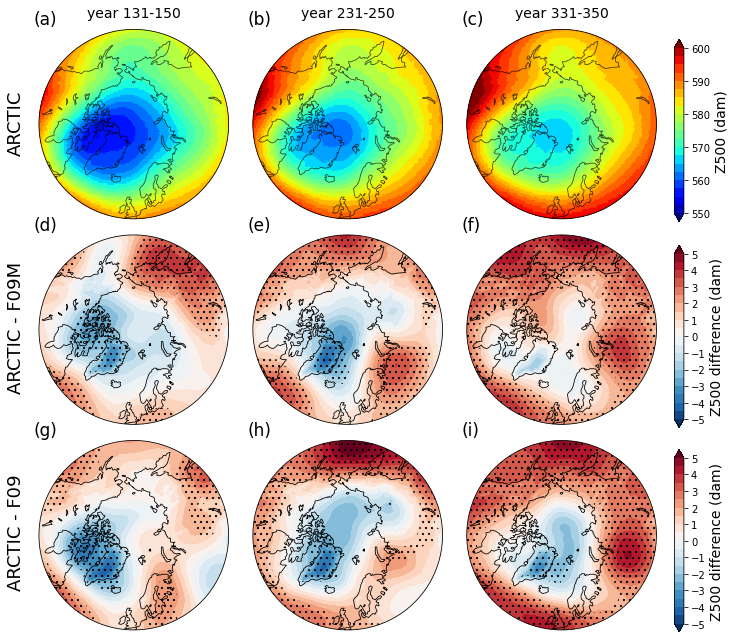

In [29]:
fig = plt.figure(figsize = (11,11))
gs=GridSpec(3,3)
plt.rcParams['axes.titlepad'] = 14

# Modify values here
cmap1 = plt.cm.jet
bounds1 = np.arange(550.,600.1,2.5)
bounds1min = [0]
bounds1max = [1000]
norm1 = mpl.colors.BoundaryNorm(bounds1, cmap1.N, extend='both')
ticks1 = np.arange(550.,600.1,10)

cmap2 = plt.cm.RdBu_r
bounds2 = np.arange(-5.,5.1,0.5)
bounds2min = [-100]
bounds2max = [100]
norm2 = mpl.colors.BoundaryNorm(bounds2, cmap2.N, extend='both')
ticks2 = np.arange(-5.,5.1,1.)

#=============ARCTIC===============
ax1 = plt.subplot(gs[0],projection=crs_np)
plot_arctic(ax1,50)
im1 = PolyCollection(ARCTIC_Z500_JJA_stab_verts, cmap=cmap1, transform=crs_ll, norm=norm1,
                     **kwd_polycollection)
im1.set_array(ARCTIC_Z500_JJA_stab_var/10)
im1.set_clim(vmin=550, vmax=600)
ax1.add_collection(im1)
ax1.add_feature(cfeature.LAND, facecolor='none')
ax1.add_feature(cfeature.COASTLINE, color='black', lw=0.8, alpha=0.7)
ax1.add_feature(cfeature.LAKES, edgecolor='black', lw=0.8, alpha=0.7, facecolor='none')
plt.text(-5000000, 5000000, '(a)', fontsize=17)
plt.text(-6300000, -1300000, 'ARCTIC', rotation=90, fontsize=18)
ax1.set_title('year 131-150', fontsize = 14)

ax2 = plt.subplot(gs[1],projection=crs_np)
plot_arctic(ax2,50)
im2 = PolyCollection(ARCTIC_Z500_JJA_mid_verts, cmap=cmap1, transform=crs_ll, norm=norm1,
                     **kwd_polycollection)
im2.set_array(ARCTIC_Z500_JJA_mid_var/10)
im2.set_clim(vmin=550, vmax=600)
ax2.add_collection(im2)
ax2.add_feature(cfeature.LAND, facecolor='none')
ax2.add_feature(cfeature.COASTLINE, color='black', lw=0.8, alpha=0.7)
ax2.add_feature(cfeature.LAKES, edgecolor='black', lw=0.8, alpha=0.7, facecolor='none')
plt.text(-5000000, 5000000, '(b)', fontsize=17)
ax2.set_title('year 231-250', fontsize = 14)

ax3 = plt.subplot(gs[2],projection=crs_np)
plot_arctic(ax3,50)
im3 = PolyCollection(ARCTIC_Z500_JJA_end_verts, cmap=cmap1, transform=crs_ll, norm=norm1,
                     **kwd_polycollection)
im3.set_array(ARCTIC_Z500_JJA_end_var/10)
im3.set_clim(vmin=550, vmax=600)
ax3.add_collection(im3)
ax3.add_feature(cfeature.LAND, facecolor='none')
ax3.add_feature(cfeature.COASTLINE, color='black', lw=0.8, alpha=0.7)
ax3.add_feature(cfeature.LAKES, edgecolor='black', lw=0.8, alpha=0.7, facecolor='none')
plt.text(-5000000, 5000000, '(c)', fontsize=17)
ax3.set_title('year 331-350', fontsize = 14)

cbar_ax3 = fig.add_axes([0.925, 0.639, 0.012, 0.23])
cb3 = fig.colorbar(im3, cax=cbar_ax3, orientation='vertical', boundaries=bounds1min+bounds1+bounds1max, ticks=ticks1)
cb3.set_label(label='Z500 (dam)', size=14)
cb3.ax.tick_params(labelsize=10)

#=============F09M===============
ax4 = plt.subplot(gs[3],projection=crs_np)
plot_arctic(ax4,50)
im4 = ax4.contourf(f09_lon2, f09_lat, -f09_ARCTIC_dZ500_JJA_stab2/10, cmap=cmap2, levels=bounds2, norm=norm2, extend='both', transform=crs_ll, zorder=1)
ax4.contourf(f09_lon, f09_lat, f09_ARCTIC_Z500_JJA_sig_stab, transform=crs_ll, hatches=['..'], alpha=0)
ax4.add_feature(cfeature.LAND, zorder=2, facecolor='none')
ax4.add_feature(cfeature.COASTLINE, zorder=3, color='black', lw=0.8)
ax4.add_feature(cfeature.LAKES, zorder=4, edgecolor='black', lw=0.8, facecolor='none')
plt.text(-5000000, 5000000, '(d)', fontsize=17)
plt.text(-6300000, -2900000, 'ARCTIC - F09M', rotation=90, fontsize=18)

ax5 = plt.subplot(gs[4],projection=crs_np)
plot_arctic(ax5,50)
im5 = ax5.contourf(f09_lon2, f09_lat, -f09_ARCTIC_dZ500_JJA_mid2/10, cmap=cmap2, levels=bounds2, norm=norm2, extend='both', transform=crs_ll, zorder=1)
ax5.contourf(f09_lon, f09_lat, f09_ARCTIC_Z500_JJA_sig_mid, transform=crs_ll, hatches=['..'], alpha=0)
ax5.add_feature(cfeature.LAND, zorder=2, facecolor='none')
ax5.add_feature(cfeature.COASTLINE, zorder=3, color='black', lw=0.8)
ax5.add_feature(cfeature.LAKES, zorder=4, edgecolor='black', lw=0.8, facecolor='none')
plt.text(-5000000, 5000000, '(e)', fontsize=17)

ax6 = plt.subplot(gs[5],projection=crs_np)
plot_arctic(ax6,50)
im6 = ax6.contourf(f09_lon2, f09_lat, -f09_ARCTIC_dZ500_JJA_end2/10, cmap=cmap2, levels=bounds2, norm=norm2, extend='both', transform=crs_ll, zorder=1)
ax6.contourf(f09_lon, f09_lat, f09_ARCTIC_Z500_JJA_sig_end, transform=crs_ll, hatches=['..'], alpha=0)
ax6.add_feature(cfeature.LAND, zorder=2, facecolor='none')
ax6.add_feature(cfeature.COASTLINE, zorder=3, color='black', lw=0.8)
ax6.add_feature(cfeature.LAKES, zorder=4, edgecolor='black', lw=0.8, facecolor='none')
plt.text(-5000000, 5000000, '(f)', fontsize=17)

cbar_ax6 = fig.add_axes([0.925, 0.379, 0.012, 0.23])
cb6 = fig.colorbar(im6, cax=cbar_ax6, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb6.set_label(label='Z500 difference (dam)', size=14)
cb6.ax.tick_params(labelsize=10)

#=============F09===============

ax7 = plt.subplot(gs[6],projection=crs_np)
plot_arctic(ax7,50)
im7 = ax7.contourf(f09_lon2, f09_lat, -f09_nohacks_ARCTIC_dZ500_JJA_stab2/10, cmap=cmap2, levels=bounds2, norm=norm2, extend='both', transform=crs_ll, zorder=1)
ax7.contourf(f09_lon, f09_lat, f09_nohacks_ARCTIC_Z500_JJA_sig_stab, transform=crs_ll, hatches=['..'], alpha=0)
ax7.add_feature(cfeature.LAND, zorder=2, facecolor='none')
ax7.add_feature(cfeature.COASTLINE, zorder=3, color='black', lw=0.8)
ax7.add_feature(cfeature.LAKES, zorder=4, edgecolor='black', lw=0.8, facecolor='none')
plt.text(-5000000, 5000000, '(g)', fontsize=17)
plt.text(-6300000, -2500000, 'ARCTIC - F09', rotation=90, fontsize=18)

ax8 = plt.subplot(gs[7],projection=crs_np)
plot_arctic(ax8,50)
im8 = ax8.contourf(f09_lon2, f09_lat, -f09_nohacks_ARCTIC_dZ500_JJA_mid2/10, cmap=cmap2, levels=bounds2, norm=norm2, extend='both', transform=crs_ll, zorder=1)
ax8.contourf(f09_lon, f09_lat, f09_nohacks_ARCTIC_Z500_JJA_sig_mid, transform=crs_ll, hatches=['..'], alpha=0)
ax8.add_feature(cfeature.LAND, zorder=2, facecolor='none')
ax8.add_feature(cfeature.COASTLINE, zorder=3, color='black', lw=0.8)
ax8.add_feature(cfeature.LAKES, zorder=4, edgecolor='black', lw=0.8, facecolor='none')
plt.text(-5000000, 5000000, '(h)', fontsize=17)

ax9 = plt.subplot(gs[8],projection=crs_np)
plot_arctic(ax9,50)
im9 = ax9.contourf(f09_lon2, f09_lat, -f09_nohacks_ARCTIC_dZ500_JJA_end2/10, cmap=cmap2, levels=bounds2, norm=norm2, extend='both', transform=crs_ll, zorder=1)
ax9.contourf(f09_lon, f09_lat, f09_nohacks_ARCTIC_Z500_JJA_sig_end, transform=crs_ll, hatches=['..'], alpha=0)
ax9.add_feature(cfeature.LAND, zorder=2, facecolor='none')
ax9.add_feature(cfeature.COASTLINE, zorder=3, color='black', lw=0.8)
ax9.add_feature(cfeature.LAKES, zorder=4, edgecolor='black', lw=0.8, facecolor='none')
plt.text(-5000000, 5000000, '(i)', fontsize=17)

# colorbar
cbar_ax9 = fig.add_axes([0.925, 0.121, 0.012, 0.23]) # for new kernel
cb9 = fig.colorbar(im9, cax=cbar_ax9, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb9.set_label(label='Z500 difference (dam)', size=14)
cb9.ax.tick_params(labelsize=10)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.15,
                    hspace=0.1)

plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/Map_Z500_Z500_diff_JJA_NH_sig.png', dpi=300, bbox_inches='tight', facecolor='w', transparent = False)